X-Ray interaction with matter phantom
Xray spectra at different energies generated using python module xpecgen ; it is set for a Tungston target, 22 mm added filtration 100 cm air gap.
Detail of xpecgen are available at https://github.com/Dih5/xpecgen


In [1]:
#import time
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib import cm
from IPython.display import clear_output

In [2]:
def read_data():
    global mu_liver
    mu_liver = pd.read_csv("mu_values_tissues/mu_liver_complete.csv", header=0)
    global mu_fat
    mu_fat = pd.read_csv("mu_values_tissues/mu_fat_complete.csv", header=0)
    global mu_air
    mu_air = pd.read_csv("mu_values_tissues/mu_air_complete.csv", header=0)
    global KV_quant_factor
    KV_quant_factor = pd.read_csv("KV_mAs_5_PercentRule/data_KV_mAs.csv", header = 0)
    

In [3]:
read_data()

In [4]:
def spectra(x):
    keV=x
    with open('spectra/'+str(keV)+"_spectrum.csv") as f, open('destination.csv', 'w') as fw: 
        writer(fw, delimiter=',').writerows(zip(*reader(f, delimiter=',')))
    global spectral_data
    spectral_data = pd.read_csv("destination.csv", header=None)
    #return (spectral_data)

    

In [5]:
def spectra(x):
    keV=x
    global spectral_data
    spectral_data = pd.read_csv('spectra/'+str(keV)+"_spectrum.csv", header=None)
    spectral_data = spectral_data.T
    #return (spectral_data)

In [6]:
#spectra(40)
#spectral_data


In [7]:
#spectral_data

Sample the spectrum. Choose KeV values at random between min and max photon energies (column one) and choose random values for intensity min to max


In [10]:
def spectral_limits():
    global maxInt
    maxInt=np.ceil(max(spectral_data[1]))
    maxInt
    global maxKeV
    maxKeV=max(spectral_data[0])
    maxKeV
    global minKeV
    minKeV=min(spectral_data[0][spectral_data[1].gt(0.01*maxInt)])
    

In [11]:
#Here is the Monte Carlo sampling".

def monte_carlo_sample(mAs, maxKev):
    factor=(spectral_data.shape[0]-1)/maxKeV
    num_samples = int(10*mAs)
    samples = np.zeros(num_samples)
    
    
    i=0
    i_total = 0
    
    while i < num_samples:
        randX= np.random.uniform(low=minKeV,high=maxKeV,size=1)
        randY= np.random.uniform(low=0.0,high=maxInt,size=1)
        if float(randY) < spectral_data[1][round(factor*float(randX))] and float(randY) > 0:
            samples[i] = round(float(randX))
            #print("{}: {}".format(i, round(float(randX))))
            i = i + 1
        i_total = i_total + 1
        
    #print("Acceptance rate: {}/{} = {}".format(i, i_total, i/i_total))
    return(samples)


def monte_carlo_sample_batch(mAs, maxKev):
    factor=(spectral_data.shape[0]-1)/maxKeV
    num_samples = int(10*mAs)
    samples = np.zeros(num_samples)
    
    batch_size = 128
    num_total_accepted_samples = 0
    while num_total_accepted_samples < num_samples:
        randX = np.random.uniform(low=minKeV,high=maxKeV,size=batch_size)
        randY = np.random.uniform(low=0.0,high=maxInt,size=batch_size)
        
        # Filter the candidate samples based on the target spectrum
        accepted_samples_mask = np.logical_and(randY < spectral_data[1][np.round(factor*randX)], randY > 0)
        accepted_samples = np.round(randX[accepted_samples_mask])
        
        samples_left = num_samples - num_total_accepted_samples
        update_from = num_total_accepted_samples
        update_to = num_total_accepted_samples + np.min([samples_left, len(accepted_samples), batch_size])
        samples[update_from:update_to] = accepted_samples[0:np.min([samples_left, len(accepted_samples), batch_size])]
        
        num_total_accepted_samples = num_total_accepted_samples + len(accepted_samples)
    
    return(samples)


In [12]:
%timeit samples = monte_carlo_sample_batch(10, 80)
%timeit samples = monte_carlo_sample(10, 80)

NameError: name 'spectral_data' is not defined

In [13]:
a = np.array([1,2,3,4.5])
np.logical_and(a>1, a < np.array([1, 3, 4, 4]))
np.round(a)
len(a)

p = pd.DataFrame([1,1,1,1])
p[0][0:2] = np.array([2,2])

In [14]:
def get_spectra_dependent_mu(spectrum_samples):
    global spect_dependent_mu
    spect_dependent_mu=pd.merge(spectrum_samples,mu_fat,on='keV',how='left')


In [15]:
def create_images(mAs,maxKeV):
    mAs_factor = KV_quant_factor.loc[KV_quant_factor['KV']== maxKeV]['mAs']
    mAs = mAs * mAs_factor.item()
    print(mAs_factor.item())
    global total_nr_photons
    total_nr_photons = 10*100*mAs# factor 10 is in the montecarlo script so evene mAs 1 has 10 photons, 100 is 10X10 pixles
    
    global image_fat
    image_fat = np.zeros((10,10))
    for  i in range (0,10,1):
        print("working on pixel row " + str(i+1)  +" out of 10 for image 1 of 3     ", end='\r')
        for j in range (0,10,1):
            spectrum_samples = pd.DataFrame(monte_carlo_sample_batch(mAs, maxKeV), columns=['keV'])
            spect_dependent_mu=pd.merge(spectrum_samples,mu_fat,on='keV',how='left')
            image_fat[i,j]= np.power(10,(-1*spect_dependent_mu['mu'].mean()))
        #time.sleep(1)
    print("",end='\n')
    #image_fat

    global image_liver
    image_liver = np.zeros((10,10))
    for  i in range (0,10,1):
        for j in range (0,10,1):
            spectrum_samples = pd.DataFrame(monte_carlo_sample_batch(mAs, maxKeV), columns=['keV'])
            spect_dependent_mu=pd.merge(spectrum_samples,mu_liver,on='keV',how='left')
            image_liver[i,j]= np.power(10,(-1*spect_dependent_mu['mu'].mean()))
            print("working on pixel row " + str(i+1)  +" out of 10 for image 2 of 3     ", end='\r')
        #time.sleep(1)
    print("",end='\n')
    #image_liver

    global image_air
    image_air = np.zeros((10,10))
    for  i in range (0,10,1):
        for j in range (0,10,1):
            spectrum_samples = pd.DataFrame(monte_carlo_sample_batch(mAs, maxKeV), columns=['keV'])
            spect_dependent_mu=pd.merge(spectrum_samples,mu_air,on='keV',how='left')
            image_air[i,j]= np.power(10,(-1*spect_dependent_mu['mu'].mean()))
            print("working on pixel row " + str(i+1)  +" out of 10 for image 3 of 3     ", end='\r')
    print("",end='\n')
    print("",end='\n')
    #time.sleep(1)
    #clear_output()    

In [16]:
#df.loc[df['column_name'] == some_value]
#test=KV_quant_factor.loc[KV_quant_factor['KV']==41]['mAs']
#test[0]
KV_quant_factor
#df.loc[df['col1'] == value]
test=KV_quant_factor.loc[KV_quant_factor['KV'] == 46]['mAs']
test.item()

2.1202964411326084

In [17]:
#fig = plt.figure
#plt.imshow(image_air, cmap='gray')
#plt.show()

In [18]:
def display_images():
    fig = plt.figure()
    ax1 = fig.add_subplot(1,3,1)
    ax1.imshow(image_liver, cmap='gray_r',vmin=0,vmax=1)
    ax2 = fig.add_subplot(1,3,2)
    ax2.imshow(image_fat, cmap='gray_r',vmin=0,vmax=1)
    ax3 = fig.add_subplot(1,3,3)
    ax3.axes.set_xlabel("Air")
    ax3.imshow(image_air, cmap='gray_r',vmin=0,vmax=1)

    ax1.axes.get_xaxis().set_visible(False)
    ax1.axes.get_yaxis().set_visible(False)
    ax1.axes.set_title('Liver')

    ax2.axes.get_xaxis().set_visible(False)
    ax2.axes.get_yaxis().set_visible(False)
    ax2.axes.set_title('Fat')

    ax3.axes.get_xaxis().set_visible(False)
    ax3.axes.get_yaxis().set_visible(False)
    ax3.axes.set_title('Air')

    liver_mean = image_liver.mean()
    liver_std = image_liver.std()
    liver_snr = 10*np.log10(liver_mean/liver_std) # in db
    fat_mean = image_fat.mean()
    fat_std = image_fat.std()
    fat_snr = 10*np.log10(fat_mean/fat_std) # in db
    air_mean = image_air.mean()
    air_std = image_air.std()
    air_snr = 10*np.log10(air_mean/air_std) # in db


    print("Liver; Mean pixel value,",liver_mean)
    print("Liver; SNR, ", liver_snr, "db")
    print("Total number of photons reaching detector ", str(int(total_nr_photons*liver_mean)), end='\n\n')
    print("Fat; Mean pixel value,",fat_mean)
    print("Fat; SNR, ", fat_snr, "db")
    print("Total number of photons reaching detector ", str(int(total_nr_photons*fat_mean)), end='\n\n')
    print("Air; Mean pixel value,",air_mean)
    print("Air; SNR, ", air_snr, "db")
    print("Total number of photons reaching detector ", str(int(total_nr_photons*air_mean)), end='\n\n')
    
    contrast = np.log10(fat_mean/liver_mean)
    print ("Fat to liver contrast,", contrast)




In [19]:
def phantom(mAs, KVp):
    if mAs <1:
        raise ValueError("mAs should be an integer between 1 and 10 inclusive")
    #if mAs >10:
    #    raise ValueError("mAs should be an integer between 1 and 10 inclusive")
    if KVp < 40:
        raise ValueError("KVp should be an integer between 40 and 120 inclusive")
    if KVp > 120:
        raise ValueError("KVp should be an integer between 40 and 120 inclusive")
    #mAs=100
    maxKeV=KVp
    #mAs=100
    #load_packages()
    read_data()
    spectra(KVp)
    spectral_limits()
    create_images(mAs,KVp)
    display_images()
    

1.0
working on pixel row 10 out of 10 for image 1 of 3     
working on pixel row 10 out of 10 for image 2 of 3     
working on pixel row 10 out of 10 for image 3 of 3     

Liver; Mean pixel value, 0.225880307332942
Liver; SNR,  5.009551445258172 db
Total number of photons reaching detector  225

Fat; Mean pixel value, 0.3908308906207795
Fat; SNR,  8.38068616075615 db
Total number of photons reaching detector  390

Air; Mean pixel value, 0.9983399665366054
Air; SNR,  33.83010795096483 db
Total number of photons reaching detector  998

Fat to liver contrast, 0.23811051234708216


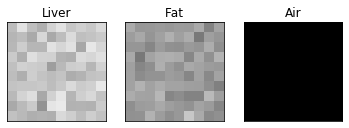

In [20]:
phantom(1,40)

1.0
working on pixel row 10 out of 10 for image 1 of 3     
working on pixel row 10 out of 10 for image 2 of 3     
working on pixel row 10 out of 10 for image 3 of 3     

Liver; Mean pixel value, 0.21565422147512225
Liver; SNR,  9.446293350386801 db
Total number of photons reaching detector  2156

Fat; Mean pixel value, 0.3893366616067013
Fat; SNR,  12.824859654747678 db
Total number of photons reaching detector  3893

Air; Mean pixel value, 0.9983192732424322
Air; SNR,  39.12853244314347 db
Total number of photons reaching detector  9983

Fat to liver contrast, 0.2565673367034783


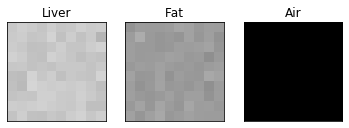

In [21]:
phantom(10,40)

1.0
working on pixel row 10 out of 10 for image 1 of 3     
working on pixel row 10 out of 10 for image 2 of 3     
working on pixel row 10 out of 10 for image 3 of 3     

Liver; Mean pixel value, 0.23016952967595522
Liver; SNR,  5.061827741289097 db
Total number of photons reaching detector  230

Fat; Mean pixel value, 0.39396756260574894
Fat; SNR,  8.439685333240769 db
Total number of photons reaching detector  393

Air; Mean pixel value, 0.9983049720885375
Air; SNR,  34.14339178620607 db
Total number of photons reaching detector  998

Fat to liver contrast, 0.2334126352921991
CPU times: user 1.94 s, sys: 52.5 ms, total: 1.99 s
Wall time: 1.93 s


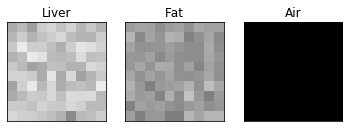

In [22]:
%time phantom(1,40)

41.56792347898636
working on pixel row 10 out of 10 for image 1 of 3     
working on pixel row 10 out of 10 for image 2 of 3     
working on pixel row 10 out of 10 for image 3 of 3     

Liver; Mean pixel value, 0.3149886097359195
Liver; SNR,  16.50231108248485 db
Total number of photons reaching detector  65467

Fat; Mean pixel value, 0.4679550082760913
Fat; SNR,  20.151395535694423 db
Total number of photons reaching detector  97259

Air; Mean pixel value, 0.998712162104044
Air; SNR,  46.74569204204944 db
Total number of photons reaching detector  207571

Fat to liver contrast, 0.17190925005773264
CPU times: user 35.3 s, sys: 156 ms, total: 35.5 s
Wall time: 35.2 s


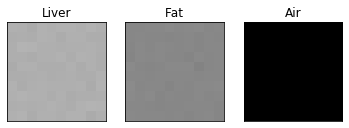

In [24]:
%time phantom(5,80)

138.00094098657996
working on pixel row 10 out of 10 for image 1 of 3     
working on pixel row 10 out of 10 for image 2 of 3     
working on pixel row 10 out of 10 for image 3 of 3     

Liver; Mean pixel value, 0.40774801006022704
Liver; SNR,  20.643995403955117 db
Total number of photons reaching detector  281348

Fat; Mean pixel value, 0.5320831017621859
Fat; SNR,  23.761595517786382 db
Total number of photons reaching detector  367139

Air; Mean pixel value, 0.998998829904818
Air; SNR,  50.00130017856002 db
Total number of photons reaching detector  689313

Fat to liver contrast, 0.11558761631738776
CPU times: user 1min 48s, sys: 253 ms, total: 1min 49s
Wall time: 1min 48s


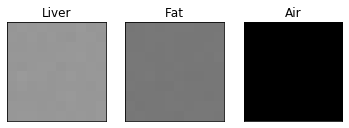

In [25]:
%time phantom(5,100)